
# Decision Trees

In [1]:
! pip install optuna
! pip install catboost

In [2]:
!pip install gdown

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import make_scorer, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [4]:
!gdown 'https://drive.google.com/uc?id=1bhS_RnzzU-NgW8Hgc_03Tl4EOlK-8cJr'

Downloading...
From: https://drive.google.com/uc?id=1bhS_RnzzU-NgW8Hgc_03Tl4EOlK-8cJr
To: /kaggle/working/train.csv
100%|████████████████████████████████████████| 170k/170k [00:00<00:00, 90.4MB/s]


# P1: Explore 

Load the dataset as a dataframe 

In [5]:
df = pd.read_csv('train.csv')

Inspect the first rows of the dataframe

In [6]:
df.head(10)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,29,No,Travel_Rarely,592,Research & Development,7,3,Life Sciences,1,1883,...,2,80,0,11,2,3,3,2,1,2
1,36,No,Travel_Rarely,884,Sales,1,4,Life Sciences,1,1585,...,1,80,0,15,5,3,1,0,0,0
2,34,No,Travel_Rarely,1326,Sales,3,3,Other,1,1478,...,4,80,0,15,2,3,13,9,3,12
3,27,No,Travel_Rarely,954,Sales,9,3,Marketing,1,1965,...,1,80,0,7,5,3,7,7,0,7
4,32,No,Travel_Rarely,929,Sales,10,3,Marketing,1,722,...,4,80,0,10,2,2,10,7,0,8
5,50,No,Travel_Frequently,1234,Research & Development,20,5,Medical,1,1606,...,3,80,1,32,3,3,30,8,12,13
6,30,No,Travel_Rarely,852,Sales,10,3,Marketing,1,1179,...,1,80,1,10,3,3,10,3,1,4
7,21,Yes,Travel_Rarely,156,Sales,12,3,Life Sciences,1,494,...,4,80,0,1,0,3,1,0,0,0
8,26,No,Travel_Rarely,1443,Sales,23,3,Marketing,1,72,...,3,80,1,5,2,2,2,2,0,0
9,27,No,Travel_Rarely,269,Research & Development,5,1,Technical Degree,1,844,...,2,80,1,9,3,3,9,8,0,8


Calculate the number of samples 

In [7]:
num_samples = df.shape[0]
print("Number of samples:", num_samples)

Number of samples: 1102


Measure the number of unique values for each column. Note that `Attrition` is the target column.

In [8]:
unique_values = df.nunique()
print("Unique values in each column:\n", unique_values)

Unique values in each column:
 Age                           43
Attrition                      2
BusinessTravel                 3
DailyRate                    736
Department                     3
DistanceFromHome              29
Education                      5
EducationField                 6
EmployeeCount                  1
EmployeeNumber              1102
EnvironmentSatisfaction        4
Gender                         2
HourlyRate                    71
JobInvolvement                 4
JobLevel                       5
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome               1027
MonthlyRate                 1082
NumCompaniesWorked            10
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptionLevel               4
TotalWorkingYears             40
TrainingTime

Check if there is a column with less than two unique values. If such a columns exists, remove it!

In [9]:
columns_to_drop = df.columns[df.nunique() < 2]
df.drop(columns=columns_to_drop, inplace=True)
df.head(10)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,29,No,Travel_Rarely,592,Research & Development,7,3,Life Sciences,1883,4,...,3,2,0,11,2,3,3,2,1,2
1,36,No,Travel_Rarely,884,Sales,1,4,Life Sciences,1585,2,...,3,1,0,15,5,3,1,0,0,0
2,34,No,Travel_Rarely,1326,Sales,3,3,Other,1478,4,...,3,4,0,15,2,3,13,9,3,12
3,27,No,Travel_Rarely,954,Sales,9,3,Marketing,1965,4,...,3,1,0,7,5,3,7,7,0,7
4,32,No,Travel_Rarely,929,Sales,10,3,Marketing,722,4,...,3,4,0,10,2,2,10,7,0,8
5,50,No,Travel_Frequently,1234,Research & Development,20,5,Medical,1606,2,...,3,3,1,32,3,3,30,8,12,13
6,30,No,Travel_Rarely,852,Sales,10,3,Marketing,1179,3,...,3,1,1,10,3,3,10,3,1,4
7,21,Yes,Travel_Rarely,156,Sales,12,3,Life Sciences,494,3,...,3,4,0,1,0,3,1,0,0,0
8,26,No,Travel_Rarely,1443,Sales,23,3,Marketing,72,3,...,3,3,1,5,2,2,2,2,0,0
9,27,No,Travel_Rarely,269,Research & Development,5,1,Technical Degree,844,3,...,3,2,1,9,3,3,9,8,0,8


In [10]:
unique_values = df.nunique()
print("Unique values in each column:\n", unique_values)

Unique values in each column:
 Age                           43
Attrition                      2
BusinessTravel                 3
DailyRate                    736
Department                     3
DistanceFromHome              29
Education                      5
EducationField                 6
EmployeeNumber              1102
EnvironmentSatisfaction        4
Gender                         2
HourlyRate                    71
JobInvolvement                 4
JobLevel                       5
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome               1027
MonthlyRate                 1082
NumCompaniesWorked            10
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StockOptionLevel               4
TotalWorkingYears             40
TrainingTimesLastYear          7
WorkLifeBalance                4
YearsAtCompany                34
YearsInCurre

Plot Mean `BusinessTravel` against `Age`. Note: Since the `BusinessTravel` column is categorical, you should first consider another column corresponding to each unique value `BusinessTravel` takes. For instance, you may assume that if someone does not travel, the value of the column for this person is 0.

In [11]:
# handle uniqueness
travel_mapping = {'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2}
df['BusinessTravelNumeric'] = df['BusinessTravel'].map(travel_mapping)

In [12]:
# Map the column
age_travel_mean = df.groupby('Age')['BusinessTravelNumeric'].mean()

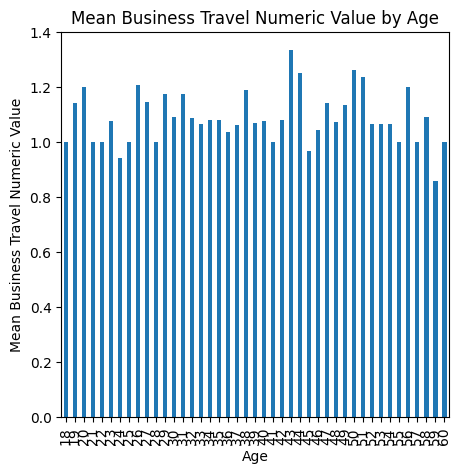

In [13]:
# plot
plt.figure(figsize=(5, 5))
age_travel_mean.plot(kind='bar')
plt.xlabel('Age')
plt.ylabel('Mean Business Travel Numeric Value')
plt.title('Mean Business Travel Numeric Value by Age')
plt.show()


Find the `Department` in which the least amount of time has passed since the last promotion of the employees on average.

In [14]:
avg_years_since_promotion = df.groupby('Department')['YearsSinceLastPromotion'].mean()
department_least_time = avg_years_since_promotion.idxmin()
print("Department with the least average time since last promotion:", department_least_time)

Department with the least average time since last promotion: Human Resources


Check if there seems to be a meaningful relationship between people's age and the years they have worked with their current manager. Your result should be a plot. 

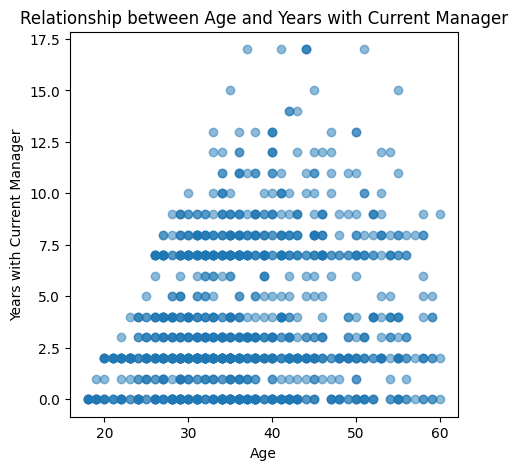

In [15]:
plt.figure(figsize=(5, 5))
plt.scatter(df['Age'], df['YearsWithCurrManager'], alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Years with Current Manager')
plt.title('Relationship between Age and Years with Current Manager')
plt.show()

base on this plot we figure out ...

Compare the average `JobSatisfaction` for employees whose `JobRole` is `Research Scientist`, `Human Resources`, `Manager`, or `Research Director` using a plot. 

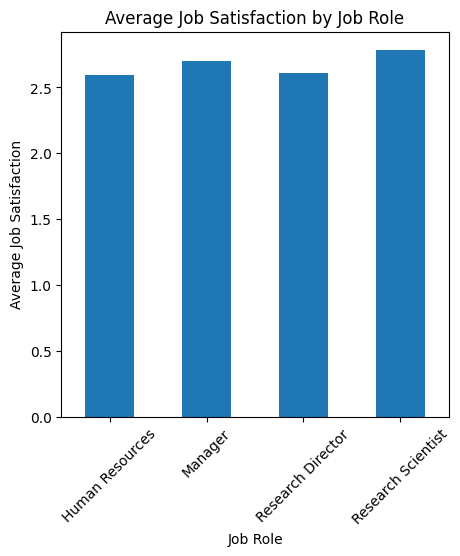

In [16]:
filtered_df = df[df['JobRole'].isin(['Research Scientist', 'Human Resources', 'Manager', 'Research Director'])]
avg_job_satisfaction = filtered_df.groupby('JobRole')['JobSatisfaction'].mean()

plt.figure(figsize=(5, 5))
avg_job_satisfaction.plot(kind='bar')
plt.xlabel('Job Role')
plt.ylabel('Average Job Satisfaction')
plt.title('Average Job Satisfaction by Job Role')
plt.xticks(rotation=45)
plt.show()

Plot the average `MonthlyIncome` against the `YearsAtCompany`.

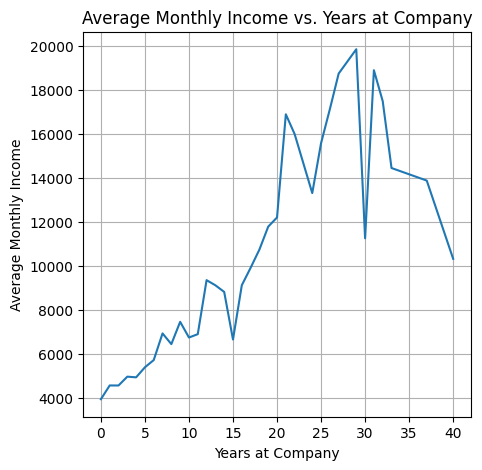

In [17]:
avg_income_by_years = df.groupby('YearsAtCompany')['MonthlyIncome'].mean()

plt.figure(figsize=(5, 5))
avg_income_by_years.plot(kind='line')
plt.xlabel('Years at Company')
plt.ylabel('Average Monthly Income')
plt.title('Average Monthly Income vs. Years at Company')
plt.grid(True)
plt.show()

# P2: Pre-processing 

Label encode all categorical columns and split the data into train and test parts. The training part will further splitted into train and validation parts. 

In [18]:
# Label encode  (1.5 points)
categorical_columns = df.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

In [19]:
# split into train and validation (0.5 point)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [20]:
# lens of train and validation datasets (0.5 point)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)

Further split the test dataframe into validation and test dataframes.

In [21]:
new_val_df, new_test_df = train_test_split(test_df, test_size=0.5, random_state=42)

Split the test and validation dataframe into feature and label part, Attrition columns is the target columns and rest of the columns should be treated as features. 

In [22]:
y_test = new_test_df['Attrition']
X_test = new_test_df.drop('Attrition', axis=1) 

y_val = new_val_df['Attrition']
X_val = new_val_df.drop('Attrition', axis=1)

check if the training dataset is label balanced.

In [23]:
class_distribution = train_df['Attrition'].value_counts()
class_proportion = class_distribution / len(train_df)
print(class_proportion)

Attrition
0    0.830303
1    0.169697
Name: count, dtype: float64


If the dataset is balanced, each class in the 'Attrition' column should have approximately equal counts or proportions. Significant disparities in these numbers indicate an imbalanced dataset.

Balance the training dataset by oversampling the class with less samples.

In [24]:
# oversampling (1.5 points)
from sklearn.utils import resample
df_majority = train_df[train_df['Attrition'] == 0]
df_minority = train_df[train_df['Attrition'] == 1]
# Oversample minority class
df_minority_oversampled = resample(df_minority,replace=True,n_samples=len(df_majority),random_state=123)
df_oversampled = pd.concat([df_majority, df_minority_oversampled])
df_oversampled = df_oversampled.sample(frac=1, random_state=123).reset_index(drop=True)
X_train_oversampled = df_oversampled.drop('Attrition', axis=1)
y_train_oversampled = df_oversampled['Attrition']


In [25]:
# check if dataset is balanced (0.5 point)
class_distribution = train_df['Attrition'].value_counts()
print("Class Distribution:\n", class_distribution)

total_count = len(train_df)
class_proportion = class_distribution / total_count
print("Class Proportions:\n", class_proportion)


Class Distribution:
 Attrition
0    548
1    112
Name: count, dtype: int64
Class Proportions:
 Attrition
0    0.830303
1    0.169697
Name: count, dtype: float64


Split the training dataframe into feature and target columns.

In [26]:
y_train = train_df['Attrition']
X_train = train_df.drop('Attrition', axis=1) 

# P3: Decision tree from scratch 

Implement decision tree based on the given functions. 

The given functions are not mandatory, you can add or remove any functions if needed.

In [27]:
class DecisionTree:

    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def _compute_entropy(self, y):
        values, counts = np.unique(y, return_counts=True)
        probabilities = counts / counts.sum()
        entropy = -np.sum(probabilities * np.log2(probabilities))
        return entropy

    def _split_data(self, X, y, feature_index, threshold):
        if isinstance(X, pd.DataFrame):
            left_mask = X.iloc[:, feature_index] <= threshold
            right_mask = X.iloc[:, feature_index] > threshold
        else:
            left_mask = X[:, feature_index] <= threshold
            right_mask = X[:, feature_index] > threshold

        return X[left_mask], X[right_mask], y[left_mask], y[right_mask]

    def _find_best_split(self, X, y):
        best_entropy = float('inf')
        best_split = None
        n_features = X.shape[1] if not isinstance(X, pd.DataFrame) else len(X.columns)

        for feature_index in range(n_features):
            if isinstance(X, pd.DataFrame):
                thresholds = np.unique(X.iloc[:, feature_index])
            else:
                thresholds = np.unique(X[:, feature_index])

            for threshold in thresholds:
                _, _, y_left, y_right = self._split_data(X, y, feature_index, threshold)
                if len(y_left) > 0 and len(y_right) > 0:
                    entropy = self._compute_entropy(y_left) * len(y_left) + \
                              self._compute_entropy(y_right) * len(y_right)
                    if entropy < best_entropy:
                        best_entropy = entropy
                        best_split = (feature_index, threshold)

        return best_split

    def _build_tree(self, X, y, depth):
        if len(np.unique(y)) == 1 or (self.max_depth is not None and depth == self.max_depth):
            return np.unique(y)[0]

        feature_index, threshold = self._find_best_split(X, y)
        if feature_index is None:
            return np.unique(y)[0]

        X_left, X_right, y_left, y_right = self._split_data(X, y, feature_index, threshold)
        left_subtree = self._build_tree(X_left, y_left, depth + 1)
        right_subtree = self._build_tree(X_right, y_right, depth + 1)

        return (feature_index, threshold, left_subtree, right_subtree)

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, 0)

    def _predict_sample(self, x, tree):
        if not isinstance(tree, tuple):
            return tree

        feature_index, threshold, left_subtree, right_subtree = tree

        # If x is a Pandas Series, convert to NumPy array
        if isinstance(x, pd.Series):
            x = x.to_numpy()

        # Check and make a prediction
        if x[feature_index] <= threshold:
            return self._predict_sample(x, left_subtree)
        else:
            return self._predict_sample(x, right_subtree)
    def predict(self, X):
        # Convert DataFrame to NumPy array if needed
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()

        return [self._predict_sample(x, self.tree) for x in X]


Define the model and train it. 

In [28]:
my_model = DecisionTree(max_depth=5)

my_model.fit(X_train, y_train)

Predict the y_train and y_val values. 

In [29]:
y_train_pred = my_model.predict(X_train)

y_val_pred = my_model.predict(X_val)

In [30]:
print(f'Train and validation accuracy are: {accuracy_score(y_train, y_train_pred)}, \
      {accuracy_score(y_val, y_val_pred)}')

print(f'Train and validation recall are: {recall_score(y_train, y_train_pred)}, \
      {recall_score(y_val, y_val_pred)}')

print(f'Train and validation f1 are: {f1_score(y_train, y_train_pred)}, \
      {f1_score(y_val, y_val_pred)}')

Train and validation accuracy are: 0.8909090909090909,       0.8636363636363636
Train and validation recall are: 0.35714285714285715,       0.1875
Train and validation f1 are: 0.5263157894736842,       0.2857142857142857


Visulize (y_train, y_train_pred) using Heatmap 

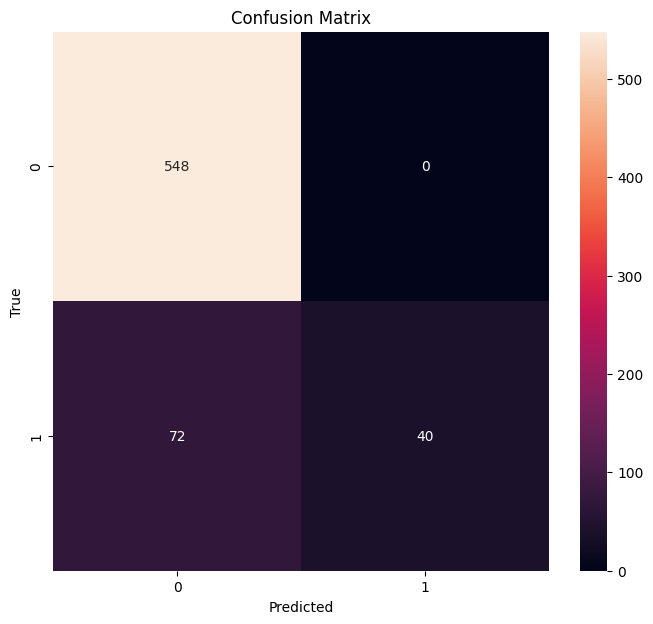

In [31]:
cm = confusion_matrix(y_train, y_train_pred)

plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Visulize (y_val, y_val_pred) using Heatmap 

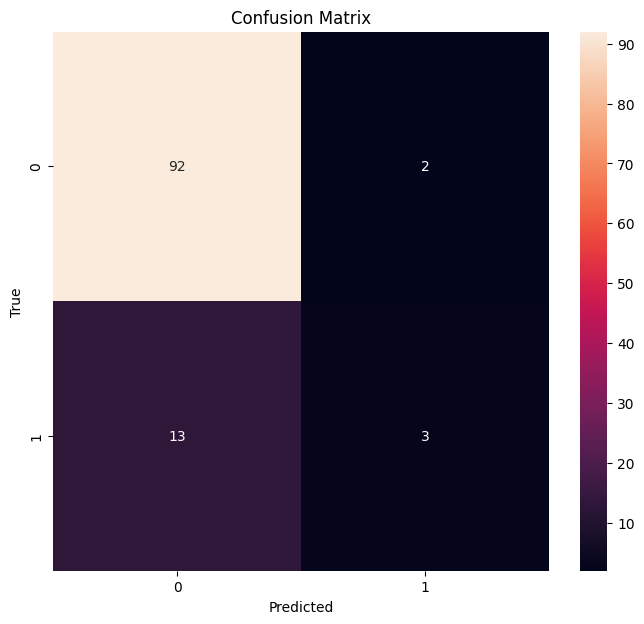

In [32]:
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# P4: Random forest from scratch 

Implement Random Forest based on the given functions. 

The given functions are not mandatory, you can add or remove any functions if needed.

In [33]:
class RandomForest:
    def __init__(self, num_trees=10, max_depth=None, random_state=None, max_features=None):
        self.num_trees = num_trees
        self.max_depth = max_depth
        self.random_state = random_state
        self.max_features = max_features
        self.trees = []

    def _bootstrap_sample(self, X, y):
        n_samples = len(X)
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        if isinstance(X, np.ndarray):
            return X[indices], y[indices]
        else:
            return X.iloc[indices], y.iloc[indices]

    def fit(self, X, y):
        np.random.seed(self.random_state)
        for _ in range(self.num_trees):
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        num_classes = np.max(tree_preds) + 1 
        return np.apply_along_axis(lambda x: np.bincount(x, minlength=num_classes).argmax(), axis=0, arr=tree_preds)


Define the model and train it. 

In [34]:
rf = RandomForest(num_trees=10, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

Predict the y_train and y_val values.

In [35]:
y_rf_train_pred = rf.predict(X_train)

y_rf_val_pred = rf.predict(X_val)

In [36]:
print(f'Train and validation accuracy are: {accuracy_score(y_train, y_rf_train_pred)}, \
      {accuracy_score(y_val, y_rf_val_pred)}')

print(f'Train and validation recall are: {recall_score(y_train, y_rf_train_pred)}, \
      {recall_score(y_val, y_rf_val_pred)}')

print(f'Train and validation f1 are: {f1_score(y_train, y_rf_train_pred)}, \
      {f1_score(y_val, y_rf_val_pred)}')

Train and validation accuracy are: 0.8878787878787879,       0.8545454545454545
Train and validation recall are: 0.3392857142857143,       0.125
Train and validation f1 are: 0.5066666666666666,       0.2


Visulize (y_train, y_train_pred) using Heatmap

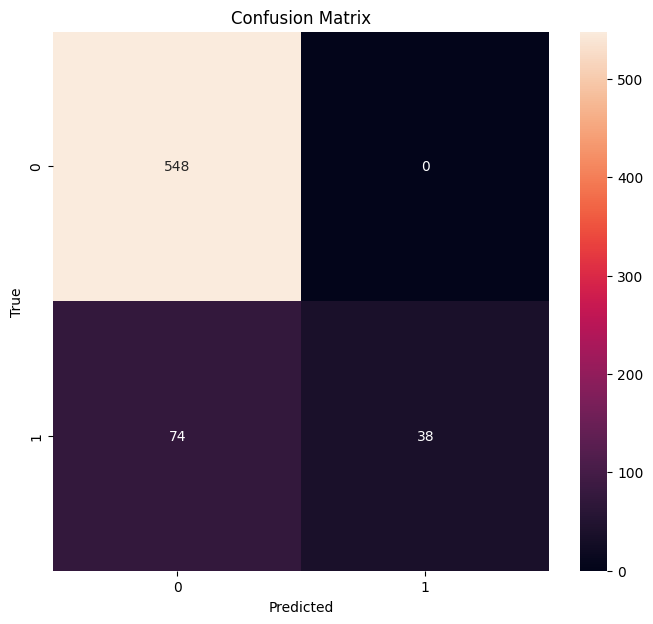

In [37]:
cm = confusion_matrix(y_train, y_rf_train_pred)

plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Visulize (y_val, y_val_pred) using Heatmap 

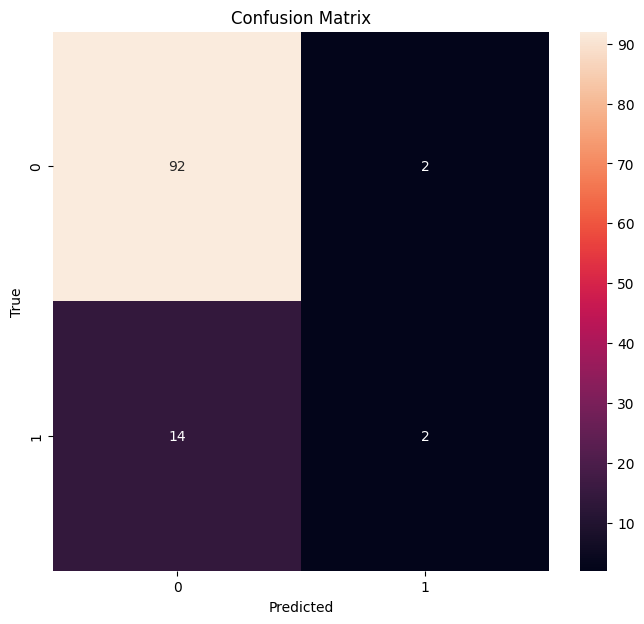

In [38]:
cm = confusion_matrix(y_val, y_rf_val_pred)

plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# P5: Decision Tree 

Fit the data to a decision tree (of sklearn) with maximum depth of 2. 

In [39]:
sklearn_model = DecisionTreeClassifier(max_depth=2)

sklearn_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

Plot the fitted decision tree. 

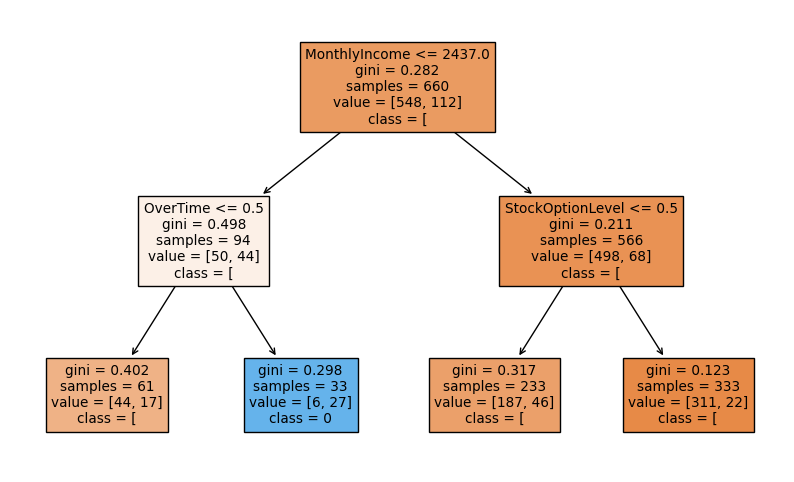

In [40]:
plt.figure(figsize=(10, 6))
plot_tree(sklearn_model, filled=True, feature_names=X_train.columns, class_names=str(sklearn_model.classes_))
plt.show()

Make predictions on training and validation set and calculate accuracy, recall and f1_score on them. 

In [41]:
y_sklearn_train_pred = sklearn_model.predict(X_train)

y_sklearn_val_pred = sklearn_model.predict(X_val)

In [42]:
print(f'Train and validation accuracy are: {accuracy_score(y_train, y_sklearn_train_pred)}, \
      {accuracy_score(y_val, y_sklearn_val_pred)}')

print(f'Train and validation recall are: {recall_score(y_train, y_sklearn_train_pred)}, \
      {recall_score(y_val, y_sklearn_val_pred)}')

print(f'Train and validation f1 are: {f1_score(y_train, y_sklearn_train_pred)}, \
      {f1_score(y_val, y_sklearn_val_pred)}')

Train and validation accuracy are: 0.8621212121212121,       0.8545454545454545
Train and validation recall are: 0.24107142857142858,       0.1875
Train and validation f1 are: 0.3724137931034483,       0.2727272727272727


Plot the confusion matrices for the training and validation datasets. 

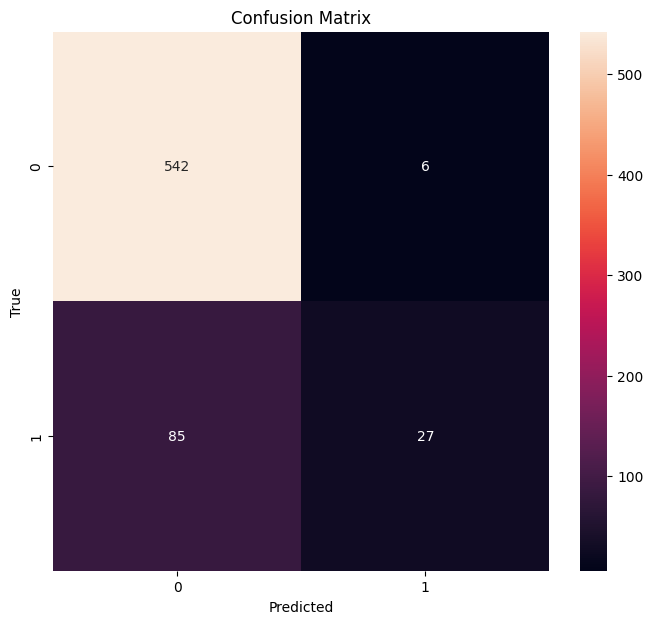

In [43]:
cm = confusion_matrix(y_train, y_sklearn_train_pred)

plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

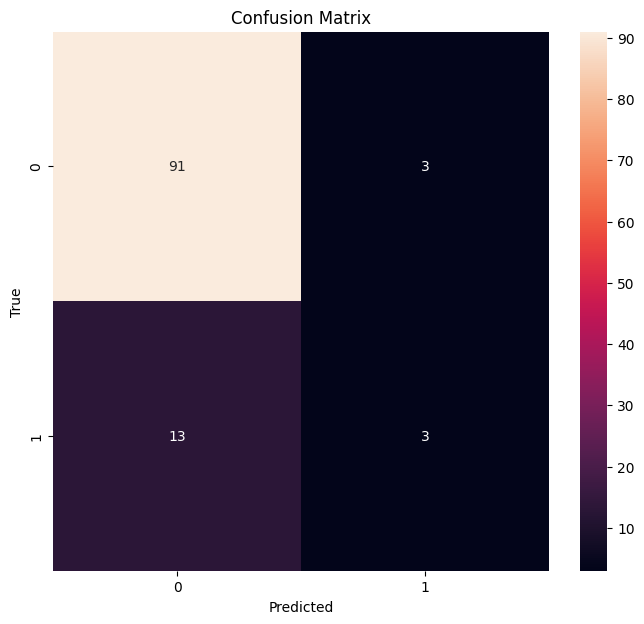

In [44]:
cm = confusion_matrix(y_val, y_sklearn_val_pred)

plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Experiment with different depth trees and plot the f1_score associated with each depth on training and valication datasets. 

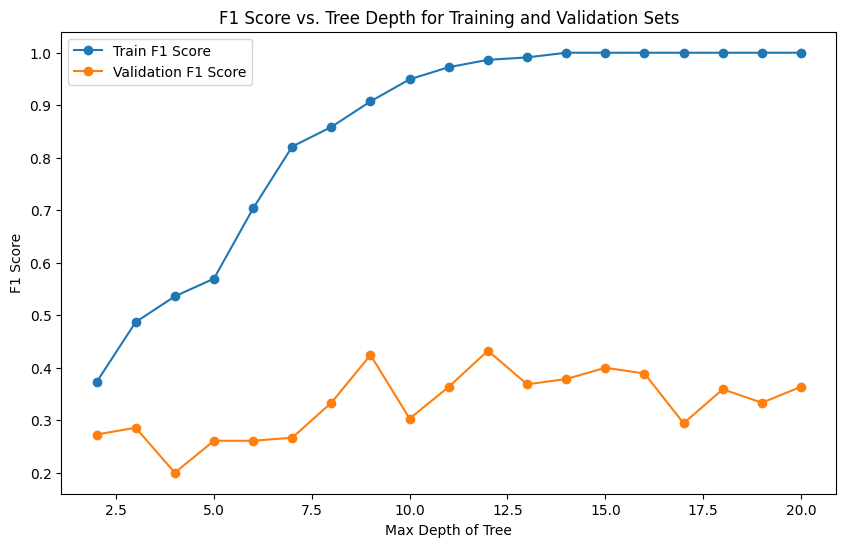

In [45]:
max_depths = range(2, 21)
f1_scores_train = []
f1_scores_val = []

for depth in max_depths:

    dt_model = DecisionTreeClassifier(max_depth=depth)
    dt_model.fit(X_train, y_train)

    y_train_pred = dt_model.predict(X_train)
    y_val_pred = dt_model.predict(X_val)

    f1_train = f1_score(y_train, y_train_pred)
    f1_val = f1_score(y_val, y_val_pred)
    f1_scores_train.append(f1_train)
    f1_scores_val.append(f1_val)

plt.figure(figsize=(10, 6))
plt.plot(max_depths, f1_scores_train, label='Train F1 Score', marker='o')
plt.plot(max_depths, f1_scores_val, label='Validation F1 Score', marker='o')
plt.xlabel('Max Depth of Tree')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Tree Depth for Training and Validation Sets')
plt.legend()
plt.show()

# P6: Random Forest 

Fit the training data to a random forest (of sklearn). 

In [46]:
sklearn_rf = RandomForestClassifier()

sklearn_rf.fit(X_train, y_train)

RandomForestClassifier()

Plot the feature importances using a bar plot.

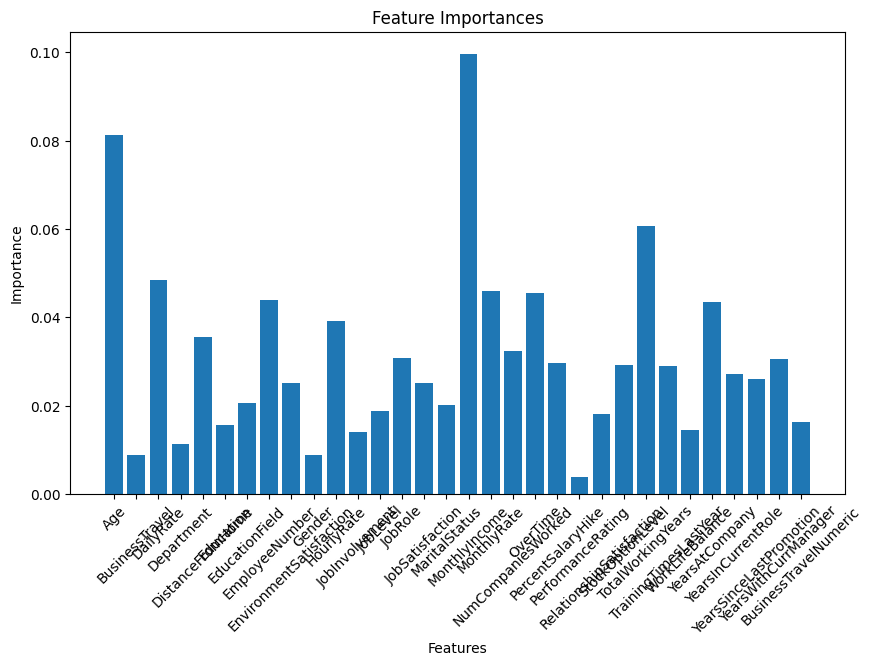

In [47]:
feature_importances = sklearn_rf.feature_importances_

feature_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=45)
plt.show()

Make predictions using the model and print the accuracy, recall, f1_score and plot the confusion matrices for training and validation data.

In [48]:
y_sklearn_rf_train_pred = sklearn_rf.predict(X_train)

y_sklearn_rf_val_pred = sklearn_rf.predict(X_val)

In [49]:
print(f'Train and validation accuracy are: {accuracy_score(y_train, y_sklearn_rf_train_pred)}, \
      {accuracy_score(y_val, y_sklearn_rf_val_pred)}')

print(f'Train and validation recall are: {recall_score(y_train, y_sklearn_rf_train_pred)}, \
      {recall_score(y_val, y_sklearn_rf_val_pred)}')

print(f'Train and validation f1 are: {f1_score(y_train, y_sklearn_rf_train_pred)}, \
      {f1_score(y_val, y_sklearn_rf_val_pred)}')

Train and validation accuracy are: 1.0,       0.8727272727272727
Train and validation recall are: 1.0,       0.25
Train and validation f1 are: 1.0,       0.36363636363636365


Plot the confusion matrices for the training and validation datasets. 

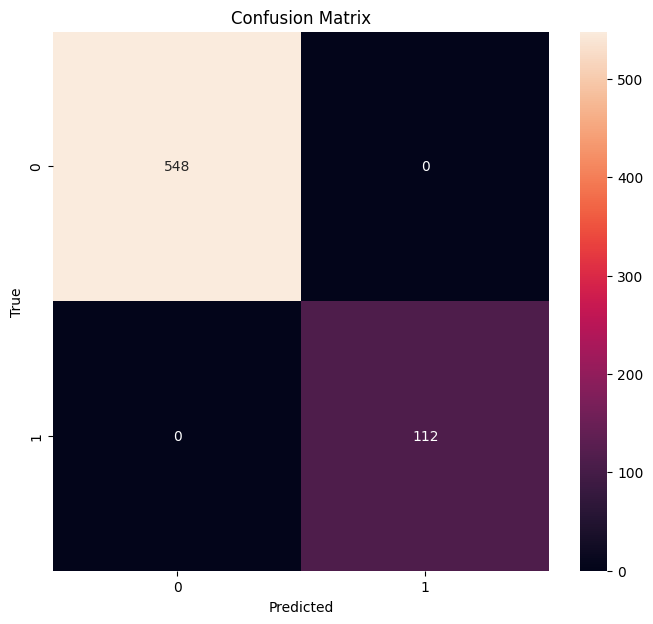

In [50]:
cm = confusion_matrix(y_train, y_sklearn_rf_train_pred)

plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

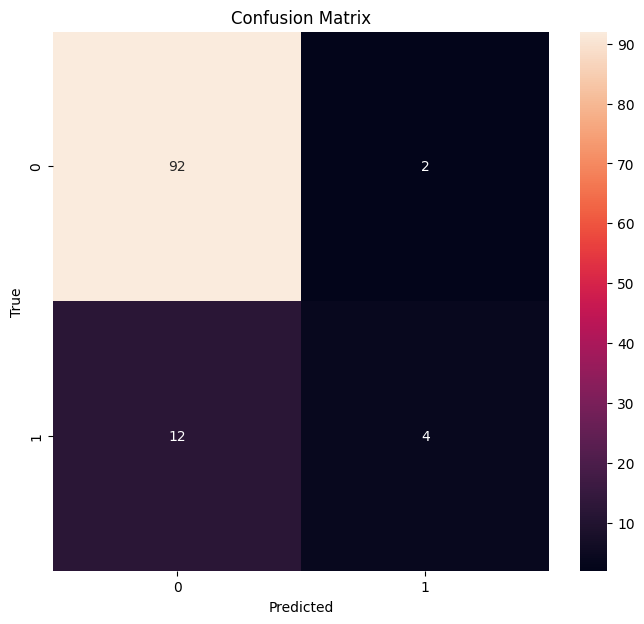

In [51]:
cm = confusion_matrix(y_val, y_sklearn_rf_val_pred)

plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# P7: Gradient Boosted Decision Trees

Fit a gradient boosted decision tree(e.g. catboost, lightgbm, xgboost).

Using the catboost library is recommended

In [52]:
catboost_model = CatBoostClassifier()

catboost_model.fit(X_train, y_train, verbose=0)

Make predictions using the model and print the accuracy, recall, f1_score and plot the confusion matrices for training and validation data. 

In [53]:
y_catboost_train_pred = catboost_model.predict(X_train)

y_catboost_val_pred = catboost_model.predict(X_val)

In [54]:
print(f'Train and test accuracy are: {accuracy_score(y_train, y_catboost_train_pred)}, \
      {accuracy_score(y_val, y_catboost_val_pred)}')

print(f'Train and test recall are: {recall_score(y_train, y_catboost_train_pred)}, \
      {recall_score(y_val, y_catboost_val_pred)}')

print(f'Train and test f1 are: {f1_score(y_train, y_catboost_train_pred)}, \
      {f1_score(y_val, y_catboost_val_pred)}')

Train and test accuracy are: 0.9924242424242424,       0.8636363636363636
Train and test recall are: 0.9553571428571429,       0.1875
Train and test f1 are: 0.9771689497716896,       0.2857142857142857


Plot the confusion matrices for the training and validation datasets.

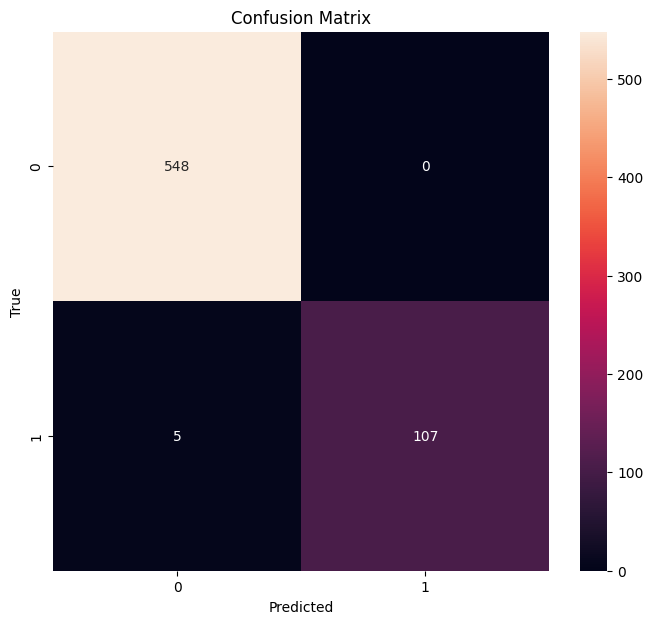

In [55]:
cm = confusion_matrix(y_train, y_catboost_train_pred)

plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

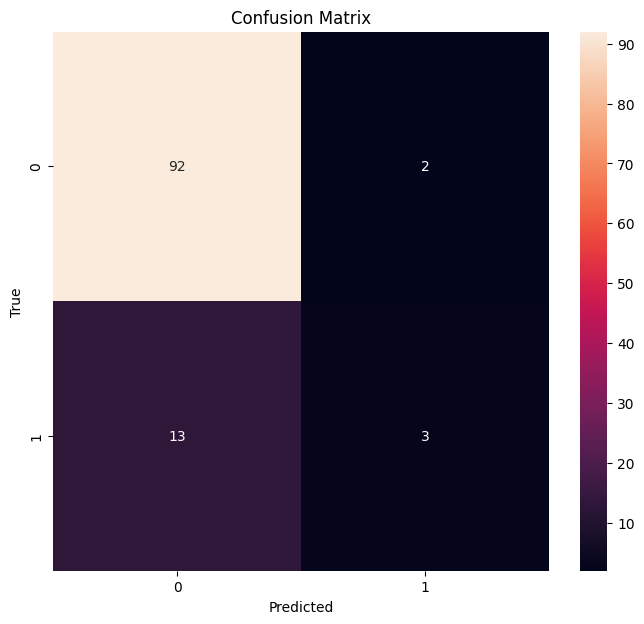

In [56]:
cm = confusion_matrix(y_val, y_catboost_val_pred)

plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# P8: Tuning parameters using optuna? 

There are many tunable parameters in Gradient boosted decision trees tuning all of them using grid search is almost impossible. There is no other choice for tuing hyperparameters unless we assume some models on behaviour of models under different hyperparameter choices e.g. the follow a gaussian process. Use the optuna library to tune the hyperparameters of gradient boosted decision tree.

In [57]:
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0),
    }

    model = CatBoostClassifier(**param, verbose=False)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

trial = study.best_trial
print('Best trial:', trial.params)


[I 2024-01-01 18:48:28,726] A new study created in memory with name: no-name-0e4bcd03-ebf3-4a6e-91e3-89030c2fc143
[I 2024-01-01 18:48:29,734] Trial 0 finished with value: 0.8636363636363636 and parameters: {'iterations': 252, 'depth': 8, 'learning_rate': 0.19504834000784693, 'l2_leaf_reg': 4.617056007832772}. Best is trial 0 with value: 0.8636363636363636.
[I 2024-01-01 18:48:30,231] Trial 1 finished with value: 0.8727272727272727 and parameters: {'iterations': 259, 'depth': 6, 'learning_rate': 0.26780553457923584, 'l2_leaf_reg': 8.198760994658532}. Best is trial 1 with value: 0.8727272727272727.
[I 2024-01-01 18:48:30,589] Trial 2 finished with value: 0.8545454545454545 and parameters: {'iterations': 264, 'depth': 5, 'learning_rate': 0.059701890755963084, 'l2_leaf_reg': 4.381245505570132}. Best is trial 1 with value: 0.8727272727272727.
[I 2024-01-01 18:48:30,854] Trial 3 finished with value: 0.8727272727272727 and parameters: {'iterations': 136, 'depth': 6, 'learning_rate': 0.0690551

Best trial: {'iterations': 295, 'depth': 4, 'learning_rate': 0.15748039590803678, 'l2_leaf_reg': 3.7076640682710473}


In [58]:
optuna_model = CatBoostClassifier(**trial.params, verbose=False)
optuna_model.fit(X_train, y_train)

y_optuna_train_pred = optuna_model.predict(X_train)
y_optuna_val_pred = optuna_model.predict(X_val)

print(f'Train and validation accuracy are: {accuracy_score(y_train, y_optuna_train_pred)}, \
      {accuracy_score(y_val, y_optuna_val_pred)}')

print(f'Train and validation recall are: {recall_score(y_train, y_optuna_train_pred)}, \
      {recall_score(y_val, y_optuna_val_pred)}')

print(f'Train and validation f1 are: {f1_score(y_train, y_optuna_train_pred)}, \
      {f1_score(y_val, y_optuna_val_pred)}')

Train and validation accuracy are: 1.0,       0.8818181818181818
Train and validation recall are: 1.0,       0.25
Train and validation f1 are: 1.0,       0.38095238095238093


Plot the confusion matrices for the training and validation datasets. 

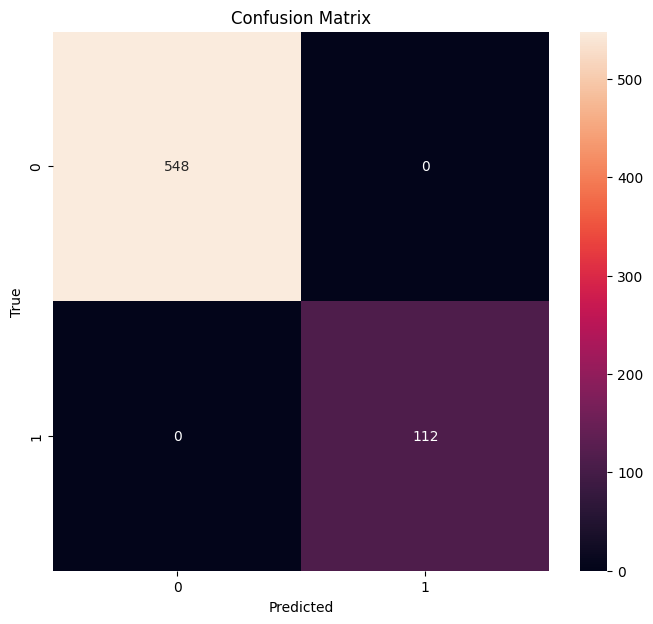

In [59]:
cm = confusion_matrix(y_train, y_optuna_train_pred)

plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

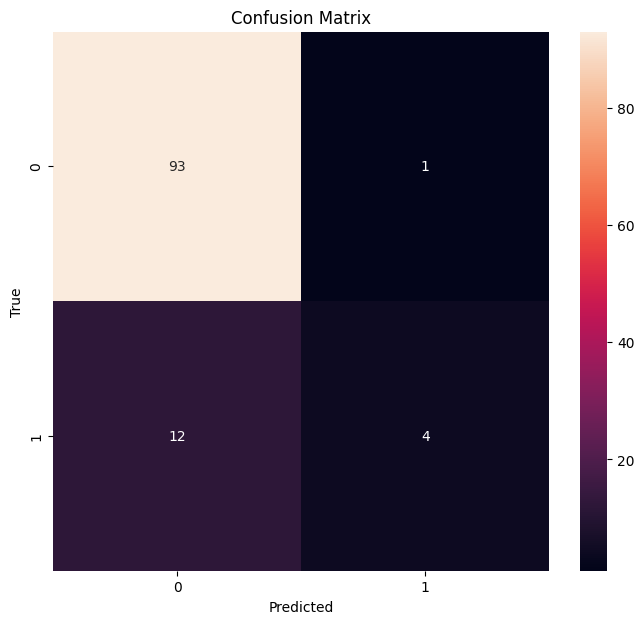

In [60]:
cm = confusion_matrix(y_val, y_optuna_val_pred)

plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# P9: Performance on testing data 

call the model on test data.

In [61]:
my_model_y_pred = my_model.predict(X_test)
rf_y_pred = rf.predict(X_test)
sklearn_model_y_pred = sklearn_model.predict(X_test)
sklearn_rf_y_pred = sklearn_rf.predict(X_test)
catboost_model_y_pred = catboost_model.predict(X_test)
optuna_model_y_pred = optuna_model.predict(X_test)

evaluate your model on the testing data using f1_score. 

In [62]:
f1_my_model = f1_score(y_test, my_model_y_pred)
f1_rf = f1_score(y_test, rf_y_pred)
f1_sklearn_model = f1_score(y_test, sklearn_model_y_pred)
f1_sklearn_rf = f1_score(y_test, sklearn_rf_y_pred)
f1_catboost_model = f1_score(y_test, catboost_model_y_pred)
f1_optuna_model = f1_score(y_test, optuna_model_y_pred)


print(f"F1 Score of my_model: {f1_my_model}")
print(f"F1 Score of rf: {f1_rf}")
print(f"F1 Score of sklearn_model: {f1_sklearn_model}")
print(f"F1 Score of sklearn_rf: {f1_sklearn_rf}")
print(f"F1 Score of catboost_model: {f1_catboost_model}")
print(f"F1 Score of optuna_model: {f1_optuna_model}")

F1 Score of my_model: 0.14814814814814814
F1 Score of rf: 0.16
F1 Score of sklearn_model: 0.16
F1 Score of sklearn_rf: 0.35714285714285715
F1 Score of catboost_model: 0.4666666666666666
F1 Score of optuna_model: 0.43749999999999994


What is the origin of loosing performance on the test set? Answer briefly here. 

Overfitting: The model might have learned specific details, including noise, from the training data, which doesn't generalize well to unseen data.

Limited Training Data: A small training dataset might not capture the full variability of real-world data, hindering the model's ability to generalize.

Complex Models: Highly intricate models can capture subtle and possibly irrelevant patterns in the training data, leading to poor performance on new data.

Over-tuned Hyperparameters: Extensive hyperparameter tuning on the training set can lead to models that are too tailored to the training data.

Data Leakage: If information from the test data leaks into the training process, it gives a false impression of the model's effectiveness.


Plot the heatmap of the confusion matrix here. 

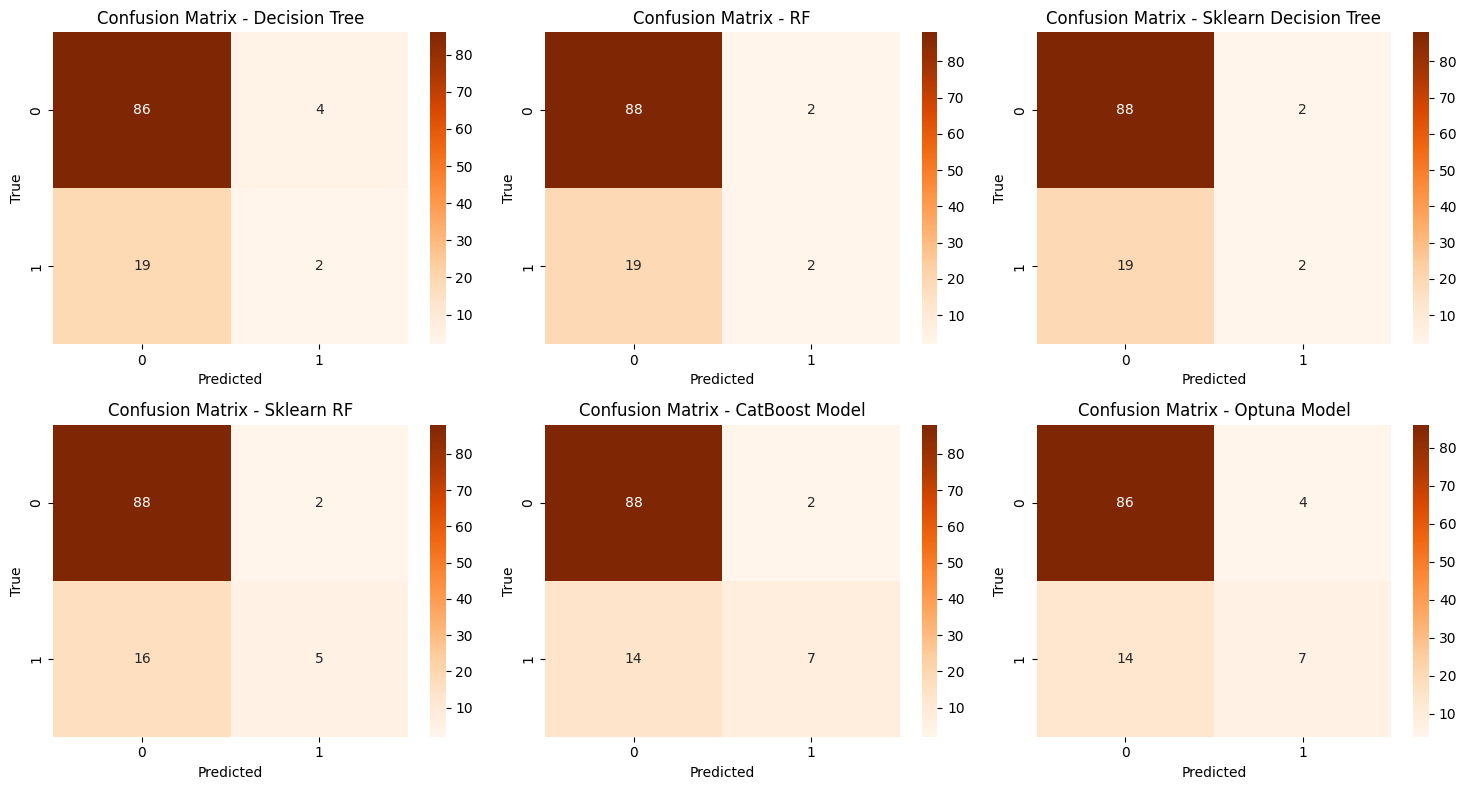

In [63]:
predictions = {
    "Decision Tree": my_model_y_pred,
    "RF": rf_y_pred,
    "Sklearn Decision Tree": sklearn_model_y_pred,
    "Sklearn RF": sklearn_rf_y_pred,
    "CatBoost Model": catboost_model_y_pred,
    "Optuna Model": optuna_model_y_pred
}

n_cols = 3
n_rows = int(len(predictions) / n_cols) + (len(predictions) % n_cols > 0)

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, (name, y_pred) in enumerate(predictions.items(), 1):
    cm = confusion_matrix(y_test, y_pred)
    plt.subplot(n_rows, n_cols, i)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Oranges')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {name}')

plt.tight_layout()
plt.show()